In [1]:
from seaturtles import *

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, shape

print('Check that the EQHazard filename is imported: %s'%(EQHazard_file))


Check that the EQHazard filename is imported: C:\Users\ahul697\Anaconda3\lib\site-packages\seaturtles\EQHazard.jar


### Define the site location

This is only for one site at a time. The rupture will be selected based on the closest rupture to this location.

In [2]:
# site name for input/output files
site_name = 'SF'

latitude = 37.79
longitude = -122.4

# search for ruptures within this distance
max_distance = 300

# set max sources
    # this number determines how many background sources you collect
    # if you are only looking for ruptures along known faults, this can be small
max_sources = 200

### create EQHazard input and output files

In [3]:
folder = 'rupture_selection/'
if not os.path.exists(folder[:-1]):
    os.makedirs(folder[:-1])

eq = site_name + '_' + str(max_distance) + 'km_' + str(max_sources) + 'sources'
eq_input_file = folder + eq + '.json'
eq_output_file = folder + eq + '_OUTPUT.json' 

In [4]:
eq_hazard = dict()
eq_hazard['Site'] = {'Type': 'SingleLocation'}
eq_hazard['Site']['Location'] = {'Latitude': latitude, 'Longitude': longitude}

eq_hazard['EqRupture'] = {'Type': 'ERF',
                          'RuptureForecast': 'WGCEP (2007) UCERF2 - Single Branch',
                          'ExportGeoJson': True,
                          'MaxDistance': max_distance,
                          'MaxSources': max_sources}

with open(eq_input_file, 'w') as f:
    json.dump(eq_hazard, f, indent=4)


In [5]:
command_run = subprocess.call(['java', '-jar', '-Xmx1g', EQHazard_file, eq_input_file, eq_output_file])

if command_run == 0:
    print('EQHazard ran successfully.')
else:
    print('There was a problem running the EQHazard.jar file, start troubleshooting.')

EQHazard ran successfully.


### load EQHazard output

In [6]:
all_seismicity = gpd.read_file(eq_output_file)  

#### this includes some background seismicity that will be removed

In [7]:
background_idx = 296 # index of the first background source
idx = all_seismicity['Source']<background_idx
ruptures = all_seismicity[idx]

# save this smaller file
eq_rupture_file = folder + eq + '_Ruptures.json'
ruptures.to_file(eq_rupture_file, driver='GeoJSON')

#### map the seismicity

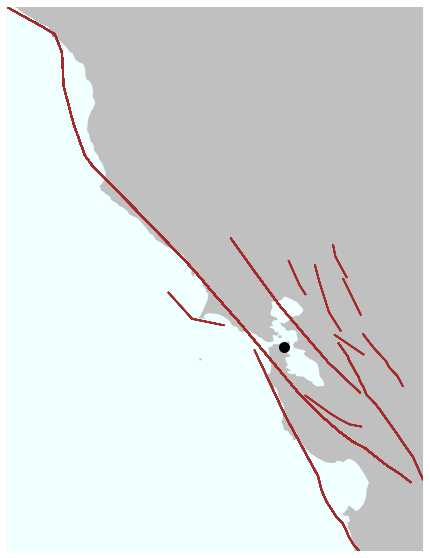

In [8]:
bounds = ruptures.total_bounds
xlim = [bounds[0], bounds[2]]
ylim = [bounds[1], bounds[3]]

points = [Point(longitude, latitude)]
site = gpd.GeoDataFrame(geometry=points)

ca_geojson_file = 'CA_polygon.geojson'
ca_map = gpd.read_file(ca_geojson_file)


fig, ax = plt.subplots(1,1, figsize=(10,10))
_ = ca_map.plot(ax=ax, color='silver')
_ = ruptures.plot(ax=ax, color='brown')

_ = site.plot(ax=ax, color='k', zorder=5, markersize=100)

_ = ax.fill_between(xlim, [ylim[0]]*2, [ylim[1]]*2,color='azure', zorder=-5)
_ = ax.set_xlim(xlim)
_ = ax.set_ylim(ylim)
_ = ax.axis('off')   
    

In [9]:
ruptures

,Name,Rupture,Source,Distance,DistanceRup,DistanceSeis,DistanceJB,DistanceX,Magnitude,Probability,MeanAnnualRate,geometry
520,N. San Andreas;SAP+SAS,0,41,13.020442,13.020442,13.355722,13.014427,-13.014197,7.25,0.003287,0.000110,"LINESTRING (-122.57410 37.78560, -122.28300 37..."
521,N. San Andreas;SAP+SAS,1,41,13.020442,13.020442,13.355722,13.014427,-13.014197,7.35,0.009787,0.000328,"LINESTRING (-122.57410 37.78560, -122.28300 37..."
522,N. San Andreas;SAP+SAS,2,41,13.020442,13.020442,13.355722,13.014427,-13.014197,7.45,0.014728,0.000495,"LINESTRING (-122.57410 37.78560, -122.28300 37..."
523,N. San Andreas;SAP+SAS,3,41,13.020442,13.020442,13.355722,13.014427,-13.014197,7.55,0.011204,0.000376,"LINESTRING (-122.57410 37.78560, -122.28300 37..."
524,N. San Andreas;SAP+SAS,4,41,13.020442,13.020442,13.355722,13.014427,-13.014197,7.65,0.004321,0.000144,"LINESTRING (-122.57410 37.78560, -122.28300 37..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15764,Calaveras;CC+CS,3,1,65.154474,65.154474,65.154474,65.017197,-24.240877,6.35,0.018072,0.000608,"LINESTRING (-121.39560 36.82570, -121.46780 36..."
15765,Calaveras;CC+CS,4,1,65.154474,65.154474,65.154474,65.017197,-24.240877,6.45,0.014597,0.000490,"LINESTRING (-121.39560 36.82570, -121.46780 36..."
15766,Calaveras;CC+CS,5,1,65.154474,65.154474,65.154474,65.017197,-24.240877,6.55,0.009909,0.000332,"LINESTRING (-121.39560 36.82570, -121.46780 36..."
15767,Calaveras;CC+CS,6,1,65.154474,65.154474,65.154474,65.017197,-24.240877,6.65,0.004240,0.000142,"LINESTRING (-121.39560 36.82570, -121.46780 36..."


### Select a Rupture for a specified Fault and Magnitude

In [10]:
def select_rupture(site, ruptures, m_mainshock, dm, fault):
    m_min = m_mainshock - dm / 2
    m_max = m_mainshock + dm / 2

    magnitude_idx = (ruptures['Magnitude'] > m_min) & (ruptures['Magnitude'] <= m_max)
    fault_idx = ruptures['Name'].str.contains(fault)
    idx = magnitude_idx & fault_idx
    r_min = ruptures[idx]['DistanceRup'].min()
    distance_idx = (ruptures['DistanceRup'] >= r_min) & (ruptures['DistanceRup'] < r_min + 0.1)
    idx = idx & distance_idx
    idx = np.around(np.median(np.where(idx)[0])).astype('int')

    return idx

In [11]:
# fault name should include this string
fault = 'San Andreas'

# magnitude
m  = 7.2
# magnitude interval
dm = 0.1
    # (if the interval is 7-7.1, the magnitude is returned as 7.05)

In [12]:
idx = select_rupture(site, ruptures, m, dm, fault)
selected_rupture = ruptures[idx:idx+1]

print('Selected source idx: %s'%(selected_rupture['Source'].values[0]))
print('Selected rupture idx: %s'%(selected_rupture['Rupture'].values[0]))
selected_rupture

Selected source idx: 127
Selected rupture idx: 636


,Name,Rupture,Source,Distance,DistanceRup,DistanceSeis,DistanceJB,DistanceX,Magnitude,Probability,MeanAnnualRate,geometry
652,N. San Andreas,636,127,13.023695,13.023695,13.363174,13.022074,-13.014313,7.25,0.000043,0.000001,"LINESTRING (-122.89915 38.16095, -122.89259 38..."


#### map selected rupture

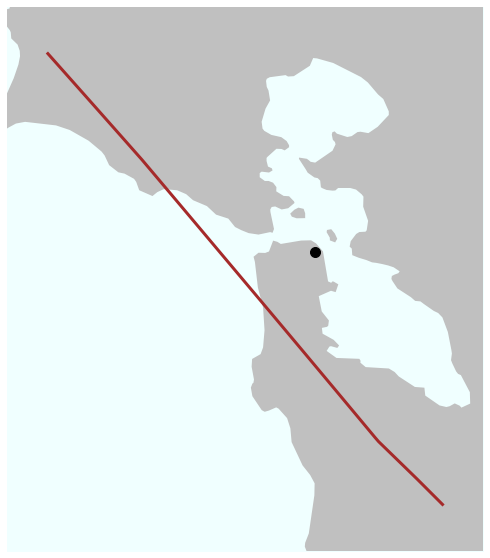

In [13]:
bounds = selected_rupture.total_bounds

xlim = [bounds[0], bounds[2]]
x_gap = 0.1*(xlim[1]-xlim[0])
xlim = [xlim[0]-x_gap, xlim[1]+x_gap]

ylim = [bounds[1], bounds[3]]
y_gap = 0.1*(ylim[1]-ylim[0])
ylim = [ylim[0]-y_gap, ylim[1]+y_gap]

fig, ax = plt.subplots(1,1, figsize=(10,10))
_ = ca_map.plot(ax=ax, color='silver')
_ = selected_rupture.plot(ax=ax, color='brown', linewidth=3)

_ = site.plot(ax=ax, color='k', zorder=5, markersize=100)

_ = ax.fill_between(xlim, [ylim[0]]*2, [ylim[1]]*2,color='azure', zorder=-5)
_ = ax.set_xlim(xlim)
_ = ax.set_ylim(ylim)
_ = ax.axis('off')   